In [1]:
# Wczytanie bibliotek

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import os
import io
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools

import numpy as np
import pandas as pd
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)

In [2]:
# Wczytanie folderu

images_dir = "C:/wikiart/"

In [3]:
# Wczytanie pliku z klasami

training_set = pd.read_csv('C:/wikiart/wclasses.csv')
training_set

,file,artist,genre,style
0,Realism/vincent-van-gogh_pine-trees-in-the-fen...,22,133,161
1,Baroque/rembrandt_the-angel-appearing-to-the-s...,20,136,144
2,Post_Impressionism/paul-cezanne_portrait-of-th...,16,135,160
3,Impressionism/pierre-auguste-renoir_young-girl...,17,131,152
4,Romanticism/ivan-aivazovsky_morning-1851.jpg,9,139,163
...,...,...,...,...
81439,Naive_Art_Primitivism/mary-fedden_butterflies-...,0,139,155
81440,Naive_Art_Primitivism/arman-manookian_watercol...,0,139,155
81441,Naive_Art_Primitivism/andre-bauchant_exotic-fl...,0,139,155
81442,Naive_Art_Primitivism/ivan-generalic_cows-in-a...,0,139,155


In [4]:
# Złożenie training_set, odrzucenie kategorii "Nieznany Gatunek"

training_imgs = list(images_dir + training_set['file'])
training_labels_1  = list(training_set['genre'])

training_set = pd.DataFrame( {'Painting': training_imgs, 'Genre' : training_labels_1})
training_set = training_set[training_set.Genre !=139]

training_set.Genre = training_set.Genre.astype(str)

In [5]:
# Ze względu na duże niezbalansowanie bazy danych wprowadzono wagi klas

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(training_set['Genre']),
                                                 training_set['Genre'])
class_weights = {i : class_weights[i] for i in range(10)}

C:\Users\jarek\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['129' '130' '131' '132' '133' '134' '135' '136' '137' '138'], y=0        133
1        136
2        135
3        131
5        131
        ... 
67789    129
67790    129
67791    129
67792    129
67793    129
Name: Genre, Length: 64992, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [6]:
# Podział na zbiory treningowy, testowy i walidacyjny

train1, test = train_test_split(training_set, test_size = 0.15, random_state = 21, stratify = training_set['Genre'])
train, val = train_test_split(train1, test_size = 0.15, random_state = 21, stratify = train1['Genre'])

In [7]:
# Przeliczenie poszczególnych klas zbioru treningowego i testowego (w celach sprawdzenia)

train_count = train.groupby(['Genre']).size().reset_index(name='count')
train_count

,Genre,count
0,129,3590
1,130,3325
2,131,7845
3,132,1374
4,133,9651
5,134,1389
6,135,10196
7,136,4723
8,137,2848
9,138,2015


In [8]:
test_count = test.groupby(['Genre']).size().reset_index(name='count')
test_count

,Genre,count
0,129,745
1,130,690
2,131,1629
3,132,285
4,133,2004
5,134,289
6,135,2117
7,136,981
8,137,591
9,138,418


In [9]:
# Preprocessing danych, podział na batche, ustalenie rozmiaru

train_input_shape = (128, 128, 3)
batch_size = 32

train_generator = ImageDataGenerator().flow_from_dataframe(
                                        dataframe = train,
                                        directory=None,
                                        x_col="Painting",
                                        y_col="Genre",
                                        class_mode="categorical",
                                        target_size=train_input_shape[0:2],
                                        batch_size=batch_size)

valid_generator = ImageDataGenerator().flow_from_dataframe(
                                        dataframe = val,
                                        directory=None,
                                        x_col="Painting",
                                        y_col="Genre",
                                        class_mode="categorical",
                                        target_size=train_input_shape[0:2],
                                        batch_size=batch_size)

test_generator = ImageDataGenerator().flow_from_dataframe(
                                        dataframe = test,
                                        directory=None,
                                        x_col="Painting",
                                        y_col="Genre",
                                        class_mode="categorical",
                                        target_size=train_input_shape[0:2],
                                        batch_size=batch_size)

C:\Users\jarek\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 420 invalid image filename(s) in x_col="Painting". These filename(s) will be ignored.
  warnings.warn(


Found 46536 validated image filenames belonging to 10 classes.


C:\Users\jarek\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 70 invalid image filename(s) in x_col="Painting". These filename(s) will be ignored.
  warnings.warn(


Found 8217 validated image filenames belonging to 10 classes.
Found 9656 validated image filenames belonging to 10 classes.


C:\Users\jarek\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 93 invalid image filename(s) in x_col="Painting". These filename(s) will be ignored.
  warnings.warn(


In [11]:
# Podział zbioru testowego na x i y w celu późniejszej wizualizacji (macierz pomyłek, wyświetlenie przykładowych obrazów) 
# przy pomocy TensorBoard
test_generator.reset()
x_test, y_test = next(test_generator)
for i in tqdm(range(int(test_generator.n//test_generator.batch_size)-1)): 
  img, label = next(test_generator)
  x_test = np.append(x_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(x_test.shape, y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [07:04<00:00,  1.42s/it]

(9632, 128, 128, 3) (9632, 10)


In [12]:
class_names =['Abstract Painting', 'Cityscape', 'Genre Painting', 'Illustration', 'Landscape', 'Nude Painting', 'Portrait', 'Religious Painting', 'Sketch And Study','Still Life','Unknown Genre']

In [13]:
# Wizualizacja w TensorBoard: wykresy przebiegu szkolenia, przykładowe obrazy, macierz pomyłek 
# (wykonywane na bieżąco, przy pomocy funkcji callback)

with file_writer.as_default():
  # Przeskalowanie obrazów, ponieważ tf.summary potrzebuje macierzy 4D (batch_size, height, width, color_channels)
  images = np.reshape(x_test[0:25], (-1, 128, 128, 3))
  tf.summary.image("Display training data", images, max_outputs=25, step=0)

In [14]:
!del -rf logs/plots
  
logdir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)
  
def plot_to_image(figure):
  """Konwersja wykresu matplotlib plot do PNG i zwrócenie.
  Później dostarczony obraz jest zamknięty i niedostępny."""
  # Plot do PNG
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  plt.close(figure)
  buf.seek(0)
  # PNG buffer do obrazu TF
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Dodanie wymiaru batcha
  print(image.shape)
  image = tf.expand_dims(image, 0)
  return image
  
def image_grid():
  """zwraca zestaw 5x5 obrazów zbioru treningowego."""
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5, 5, i + 1, title = class_names[np.int(np.where(y_test[i] ==1)[0])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    
  return figure
  
figure = image_grid()
with file_writer.as_default():
  tf.summary.image("Training data", plot_to_image(figure), step=0)

Parameter format not correct - "plots".
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floa

(720, 720, 4)


In [15]:
def plot_confusion_matrix(cm, class_names):
  """  
  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
  
  # Normalizacja macierzy pomyłek
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
  
  # Ustawienie koloru tekstu kontrastującego z kolorem kafelka
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  
# Zdefiniowanie callbacku TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  test_pred_raw = model.predict(x_test)
  test_pred = np.argmax(test_pred_raw, axis=1)
  y_test_cls = np.argmax(y_test, axis=1)
  
  cm = confusion_matrix(y_test_cls, test_pred)
  
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)
  
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)
  
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [16]:
# Wczytanie modelu ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [17]:
# Dodanie dodatkowych warstw na wyjściu

X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(10, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [18]:
# Wczytanie optymalizatora

optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [19]:
#Podsumowanie modelu

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [24]:
%reload_ext tensorboard
%tensorboard --logdir logs/image

In [25]:
#Część pierwza szkolenia - wszystkie warstwy

checkpoint = ModelCheckpoint("GENRE7_best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

epochs=25
history = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  callbacks=[tensorboard_callback, cm_callback,checkpoint],
  class_weight=class_weights
)

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5236.

Epoch 1/25
1455/1455 [==============================] - 1911s 1s/step - loss: 1.5862 - accuracy: 0.4845 - val_loss: 1.2330 - val_accuracy: 0.6367
(576, 576, 4)

Epoch 00001: loss improved from inf to 1.40392, saving model to GENRE7_best_model.hdf5
Epoch 2/25
1455/1455 [==============================] - 1884s 1s/step - loss: 1.0203 - accuracy: 0.6890 - val_loss: 1.0907 - val_accuracy: 0.6651
(576, 576, 4)

Epoch 00002: loss improved from 1.40392 to 0.99584, saving model to GENRE7_best_model.hdf5
Epoch 3/25
1455/1455 [==============================] - 1896s 1s/step - loss: 0.7189 - accuracy: 0.7592 - val_loss: 1.0683 - val_accuracy: 0.6563
(576, 576, 4)

Epoch 00003: loss improved from 0.99584 to 0.72769, saving model to GENRE7_best_model.hdf5
Epoch 4/25
1455/1455 [==============================] - 1893s 1s/step - loss: 0.4824 - accuracy: 0.8245 - val_loss: 0.9754 - val_accuracy: 0.6928
(576, 576, 4)

Epoch 00004: loss improved from 0.72769 to 0.49789, saving model to GENRE7_best_model.h

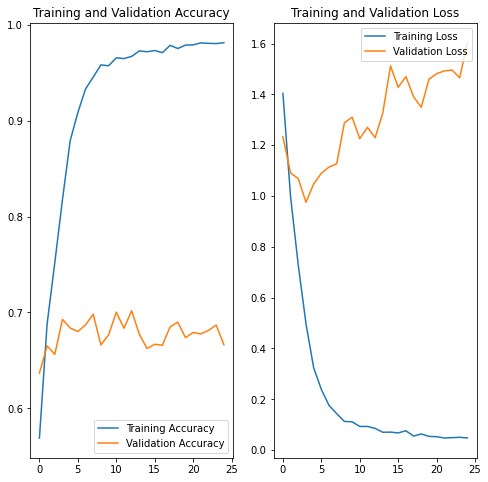

In [27]:
# Przebieg części pierwszej szkolenia

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# Zapisanie modelu 

model.save('C:/wikiart/Model_GENRE7pre.h5') 
model.save('C:/wikiart/Model_GENRE7pre.hpf5') 

INFO:tensorflow:Assets written to: C:/wikiart/Model_GENRE7pre.hpf5\assets


In [29]:
# Sprawdzenie dokładności przewidywań modelu na danych treningowych i testowych

score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

C:\Users\jarek\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1455/1455 [==============================] - 1593s 1s/step - loss: 0.0485 - accuracy: 0.9846
Prediction accuracy on train data = 0.984614372253418


In [30]:
score = model.evaluate_generator(test_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

302/302 [==============================] - 330s 1s/step - loss: 1.5522 - accuracy: 0.6719
Prediction accuracy on CV data = 0.6719138622283936


In [31]:
# Nowy checkpoint dla drugiej części szkolenia

checkpoint2 = ModelCheckpoint("GENRE72_best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [32]:
# Część druga szkolenia - zostawienie warstw z architektury ResNet50 i ponowne nauczanie pozostałych warstw 

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

epochs = 15
history2 = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  callbacks=[tensorboard_callback, cm_callback,checkpoint2],
  class_weight=class_weights
)

Epoch 1/15
1455/1455 [==============================] - 1893s 1s/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 1.4987 - val_accuracy: 0.6850
(576, 576, 4)

Epoch 00001: loss improved from inf to 0.01730, saving model to GENRE72_best_model.hdf5
Epoch 2/15
1455/1455 [==============================] - 1869s 1s/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 1.4614 - val_accuracy: 0.6932
(576, 576, 4)

Epoch 00002: loss improved from 0.01730 to 0.00775, saving model to GENRE72_best_model.hdf5
Epoch 3/15
1455/1455 [==============================] - 1871s 1s/step - loss: 0.0044 - accuracy: 0.9998 - val_loss: 1.5015 - val_accuracy: 0.6830
(576, 576, 4)

Epoch 00003: loss improved from 0.00775 to 0.00489, saving model to GENRE72_best_model.hdf5
Epoch 4/15
1455/1455 [==============================] - 1869s 1s/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 1.4513 - val_accuracy: 0.6951
(576, 576, 4)

Epoch 00004: loss improved from 0.00489 to 0.00446, saving model to GENRE72_best_mod

In [33]:
# Zapisanie modelu 

model.save('C:/wikiart/Model_GENRE7.h5') 
model.save('C:/wikiart/Model_GENRE7.hpf5') 

INFO:tensorflow:Assets written to: C:/wikiart/Model_GENRE7.hpf5\assets


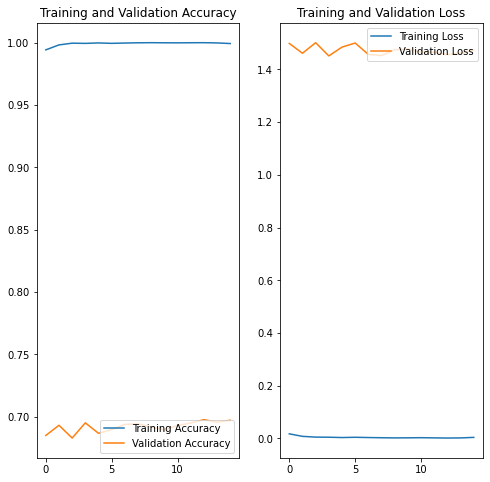

In [34]:
# Przebieg części drugiej szkolenia

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# Sprawdzenie dokładności przewidywań modelu na danych treningowych i testowych
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

C:\Users\jarek\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1455/1455 [==============================] - 1646s 1s/step - loss: 0.0024 - accuracy: 0.9999
Prediction accuracy on train data = 0.9998710751533508


In [36]:
score = model.evaluate_generator(test_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

302/302 [==============================] - 339s 1s/step - loss: 1.4434 - accuracy: 0.6975
Prediction accuracy on CV data = 0.6974937915802002
